<a href="https://colab.research.google.com/github/ralsouza/predicting_santander_customer_satisfaction/blob/main/notebooks/01_predicting_santander_customer_satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Santander Customer Satisfaction

Customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

Santander Bank is asking to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

In this project, we'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

Source: [Kaggle: Santander Customer Satisfaction](https://www.kaggle.com/c/santander-customer-satisfaction)

## Business Problem: 
Identify dissatisfied customers before leave the Santander services with 70% of accuracy.

# PySpark Setup
[A Must-Read Guide on How to Work with PySpark on Google Colab for Data Scientists!](https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/)

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [3]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [4]:
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()

In [7]:
# Optional: to know the location where Spark is installed, use findspark.find()
findspark.find()

'/content/spark-3.0.1-bin-hadoop2.7'

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("santander_satisfaction")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [9]:
spark

# Import libraries

In [10]:
from pyspark.sql import Row
from pyspark.sql.functions import col, lit, regexp_replace, array, expr, when, udf, isnan, count

# Check datatypes: https://spark.apache.org/docs/latest/sql-ref-datatypes.html
from pyspark.sql.types import BooleanType, FloatType

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

# Load data
You are provided with an anonymized dataset containing a large number of numeric variables. The `TARGET` column is the variable to predict. It equals `one` for unsatisfied customers and `0` for satisfied customers.

The task is to predict the probability that each customer in the test set is an unsatisfied customer.

**File descriptions:**
*   train.csv - the training set including the target
*   test.csv - the test set without the target




## Train data

In [ ]:
train = spark.read.csv('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train.csv', header=True, inferSchema=True)
train.cache()

In [ ]:
train.printSchema()

In [ ]:
train.show(5)

# Exploratory data analysis

In [ ]:
# Shape
print(train.count(),'x',len(train.columns))

76020 x 371


In [ ]:
# Target distribuition
# Happy customers have TARGET == 0, unhappy custormers have TARGET == 1

dist_target = train.groupBy('TARGET').count() \
  .withColumn('percentage', 100 * col('count') / train.count())

dist_target.show()

+------+-----+------------------+
|TARGET|count|        percentage|
+------+-----+------------------+
|     1| 3008|3.9568534596158904|
|     0|73012| 96.04314654038411|
+------+-----+------------------+



## var3: nationality of the customer

In [ ]:
# Top 20 most common values

# 116 values in column var3 are -999999
# var3 is suspected to be the nationality of the customer
# -999999 would mean that the nationality of the customer is unknown

train.groupBy('var3').count().sort(col('count').desc()).show()

In [ ]:
# Count -999999 values
train.filter(train['var3'] == -999999).count()

116

In [ ]:
train.show()

In [ ]:
# Replace -999999 in var3 column with most common value 2 
# See https://www.kaggle.com/cast42/santander-customer-satisfaction/debugging-var3-999999
# for details
train2 = train.withColumn('var3', \
                          when(train['var3'] == -999999, 2).otherwise(col('var3')))

In [ ]:
# Check replaced values
train2.filter(train2['var3'] == -999999).count()

0

In [ ]:
train2.select('var3').summary().show()

+-------+------------------+
|summary|              var3|
+-------+------------------+
|  count|             76020|
|   mean|2.7164825046040515|
| stddev|  9.44797132801507|
|    min|                 0|
|    25%|                 2|
|    50%|                 2|
|    75%|                 2|
|    max|               238|
+-------+------------------+



In [ ]:
train2.show()

## Add feature that counts the number of zeros in a row

In [ ]:
# Removes TARGET variable
X = train2.drop('TARGET')

# Select only TARGET variable
y = train2.select('TARGET')

In [ ]:
# Null values
X.where(col('var3').isNull()).count()

0

In [ ]:
# Not Null values
X.where(col('var3').isNotNull()).count()

76020

In [ ]:
# Counting 0s in a row - row wise operation
X = X.withColumn("n0", sum(when(X[col] == 0, 1).otherwise(0) for col in X.columns))

# Merge n0 column into train dataset
train3 = train.join(X.select('n0','ID'),on=['ID'],how='outer')

train3.cache()

## num_var4 : number of bank products

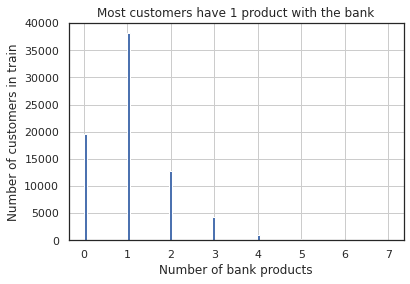

In [ ]:
# According to dmi3kno (see https://www.kaggle.com/cast42/santander-customer-satisfaction/exploring-features/comments#115223)
# num_var4 is the number of products. Let's plot the distribution:
train3.toPandas().num_var4.hist(bins=100)
plt.xlabel('Number of bank products')
plt.ylabel('Number of customers in train')
plt.title('Most customers have 1 product with the bank')
plt.show()

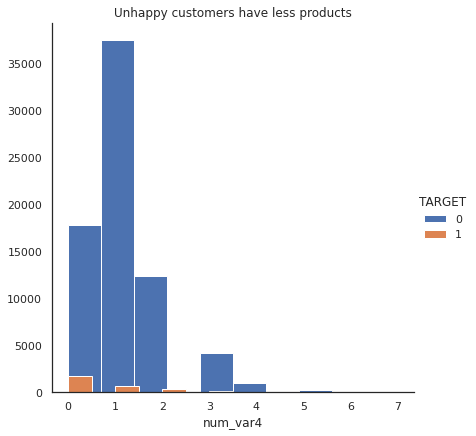

In [ ]:
# Let's look at the density of the of happy/unhappy customers in function of the number of bank products
sns.FacetGrid(train3.toPandas(), hue='TARGET', size=6)\
  .map(plt.hist,'num_var4')\
  .add_legend()
plt.title('Unhappy customers have less products')
plt.show()

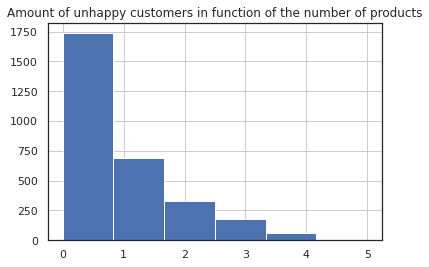

In [ ]:
train3.toPandas()[train3.toPandas().TARGET == 1].num_var4.hist(bins=6)
plt.title('Amount of unhappy customers in function of the number of products')
plt.show()

##Var38
Var38 is suspected to be the mortage value with the bank. If the mortage is with another bank the national average is used. 
See https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19895/var38-is-mortgage-value



*   var38 is important according to XGBOOST see https://www.kaggle.com/cast42/santander-customer-satisfaction/xgboost-with-early-stopping/files
*   Also RFC thinks var38 is important see https://www.kaggle.com/tks0123456789/santander-customer-satisfaction/data-exploration/notebook
*   Var38 is suspected to be the mortage value with the bank. If the mortage is with another bank the national average is used. See https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19895/var38-is-mortgage-value
*   dmi3kno says that var38 is value of the customer: https://www.kaggle.com/cast42/santander-customer-satisfaction/exploring-features/comments#115223










In [ ]:
sum_train3_var38 = train3.select('var38').summary()

In [ ]:
sum_train3_var38.show()

+-------+------------------+
|summary|             var38|
+-------+------------------+
|  count|             76020|
|   mean|117235.80943037667|
| stddev|182664.59850287266|
|    min|           5163.75|
|    25%|          67854.57|
|    50%|          106412.1|
|    75%|          118725.9|
|    max|     2.203473876E7|
+-------+------------------+



In [ ]:
# How is var38 looking when customer is unhappy?
train3.select('var38').where(train3['TARGET'] == 1).summary().show()

+-------+------------------+
|summary|             var38|
+-------+------------------+
|  count|              3008|
|   mean| 99678.28059046788|
| stddev|106309.81149003105|
|    min|          11136.63|
|    25%|          57159.12|
|    50%|          86191.05|
|    75%|  117310.979016494|
|    max|         3988595.1|
+-------+------------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb1440c780>]],
      dtype=object)

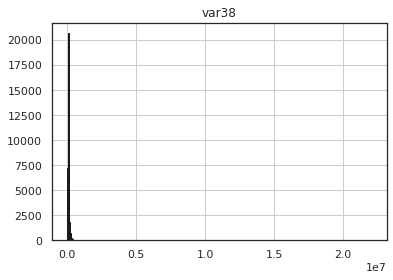

In [ ]:
# There is a pike
train3.select('var38').toPandas().hist(bins=1000,ec='k')

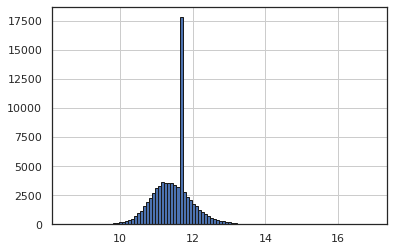

In [ ]:
# Apply log normalization in each value in var38
# https://campus.datacamp.com/courses/preprocessing-for-machine-learning-in-python/standardizing-data?ex=4
# Argument ec = edgecolor
train3.toPandas().var38.map(np.log).hist(bins=100,ec='k')

In [ ]:
# Where is the spike between 11 and 12  in the log plot?
train3.toPandas().var38.map(np.log).mode()

0    11.672584
dtype: float64

In [ ]:
# What are the most common values for var38?
train3.groupBy('var38').count().sort(col('count').desc()).show()

# OBS: The np.log(117310.979016494) is equal to 11.672584

+----------------+-----+
|           var38|count|
+----------------+-----+
|117310.979016494|14868|
|       451931.22|   16|
|       463625.16|   12|
|        104563.8|   11|
|       288997.44|   11|
|       236690.34|    8|
|       329603.97|    7|
|       128318.52|    7|
|        67088.31|    7|
|       104644.41|    7|
|       125722.44|    7|
|       163432.47|    6|
|        97639.56|    6|
|       185385.69|    6|
|       168733.62|    6|
|         70813.8|    6|
|       100466.73|    6|
|       105260.88|    6|
|        63820.89|    5|
|        171932.7|    5|
+----------------+-----+
only showing top 20 rows



In [ ]:
np.log(117310.979016494)

11.672583628015142

In [ ]:
# the most common value is very close to the mean of the other values
# mean 117217.53330847736
train3.select('var38').where(train3['var38'] != 117310.979016494).summary().show()

+-------+------------------+
|summary|             var38|
+-------+------------------+
|  count|             61152|
|   mean|117217.53330847727|
| stddev| 203663.7200319098|
|    min|           5163.75|
|    25%|          61671.24|
|    50%|          88893.87|
|    75%|          132496.2|
|    max|     2.203473876E7|
+-------+------------------+



In [ ]:
# what if we exclude the most common value
train3.where(train3['var38'] != 117310.979016494)\
    .groupBy('var38')\
    .count()\
    .sort(col('count')\
    .desc())\
    .show()

+---------+-----+
|    var38|count|
+---------+-----+
|451931.22|   16|
|463625.16|   12|
|288997.44|   11|
| 104563.8|   11|
|236690.34|    8|
| 67088.31|    7|
|128318.52|    7|
|329603.97|    7|
|104644.41|    7|
|125722.44|    7|
|163432.47|    6|
| 97639.56|    6|
|105260.88|    6|
|100466.73|    6|
|  70813.8|    6|
|168733.62|    6|
|185385.69|    6|
| 63820.89|    5|
|126065.04|    5|
|229351.65|    5|
+---------+-----+
only showing top 20 rows



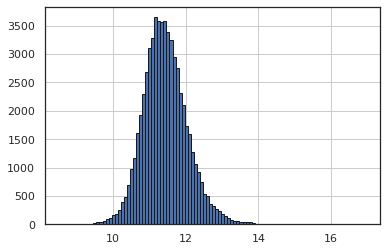

In [ ]:
# Look at the distribution
train3.toPandas().loc[~np.isclose(train3.select("var38")\
                                  .rdd.flatMap(lambda x: x)\
                                  .collect(), 117310.979016494),'var38']\
                                  .map(np.log).hist(bins=100,ec='k')

Above plot suggest we split up var38 into two variables:
* `var38mc == True` when `var38` has the most common value and `False` otherwise;
* `logvar38` is log transformed feature when `var38mc` is `0`, zero otherwise;

In [ ]:
# train.loc[train['var38mc'], 'logvar38'] = 0

In [ ]:
udf_var38mc = udf(lambda x: bool(np.isclose(x, 117310.979016494)), BooleanType())

In [ ]:
udf_logvar38 = udf(lambda x: float(np.log(x)), FloatType())

In [ ]:
train4 = train3.withColumn('var38mc', udf_var38mc('var38'))

In [ ]:
train5 = train4.withColumn('logvar38', when(col('var38mc') == False, udf_logvar38('var38'))\
                                      .otherwise(0.0))

In [ ]:
# Not run, just to test the logic
# train5 = train4.withColumn('logvar38', when(col('var38mc') == False, udf_logvar38('var38')))

In [ ]:
# Check NaN values in logvar38 and var38mc
train5.select([count(when(isnan('logvar38') | col('logvar38').isNull(), True)).alias('logvar38_isnan?')]).show()

+---------------+
|logvar38_isnan?|
+---------------+
|              0|
+---------------+



In [ ]:
# isnan() doesn't support boolen values
train5.select([count(when(col('var38mc').isNull(), True)).alias('var38mc_isnan?')]).show()

+--------------+
|var38mc_isnan?|
+--------------+
|             0|
+--------------+



In [ ]:
train5.show()

## Var15
The most important feature for XGBoost is var15. According to [a Kaggle form](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19291/data-dictionary/110414#post110414) post var15 is the age of the customer. 
Let's explore var15

In [ ]:
train5.select('var15').summary().show()

+-------+------------------+
|summary|             var15|
+-------+------------------+
|  count|             76020|
|   mean| 33.21286503551697|
| stddev|12.956485816411226|
|    min|                 5|
|    25%|                23|
|    50%|                28|
|    75%|                40|
|    max|               105|
+-------+------------------+



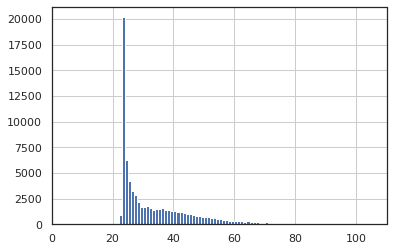

In [ ]:
# Looks more normal, plot the histogram
# train3.toPandas().var38.map(np.log).hist(bins=100,ec='k')
train5.toPandas().var15.hist(bins=100)

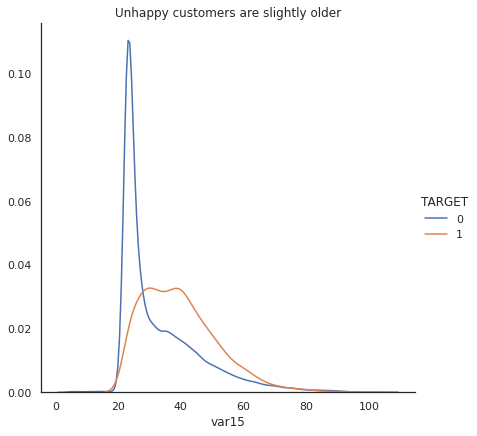

In [ ]:
# Let's look at the density of the age of happy/unhappy customers
sns.FacetGrid(train5.toPandas(), hue='TARGET', size=6)\
  .map(sns.kdeplot,'var15')\
  .add_legend()
plt.title('Unhappy customers are slightly older')
plt.show()

## saldo_var30

(0.0, 3458077.32)

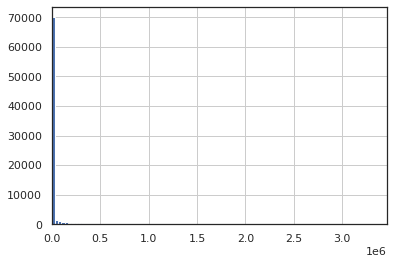

In [ ]:
train5.toPandas().saldo_var30.hist(bins=100)
plt.xlim(0,train5.toPandas().saldo_var30.max())

In [ ]:
udf_log_var = udf(lambda x: float(np.log(x)), FloatType())

In [ ]:
train6 = train5.withColumn('log_saldo_var30', udf_log_var('saldo_var30'))

In [ ]:
# Log 0.0 is converted to NaN values to not appear as -Infinity values
train7 = train5.withColumn('log_saldo_var30', when(col('saldo_var30') != 0.0, udf_log_var('saldo_var30'))\
                                             .otherwise(np.nan))

In [ ]:
train7.select('saldo_var30','log_saldo_var30').show()

+-----------+------------------+
|saldo_var30|   log_saldo_var30|
+-----------+------------------+
|      780.0| 6.659294128417969|
|        0.0|               NaN|
|        0.0|               NaN|
|       90.0| 4.499809741973877|
|    30000.0|10.308952331542969|
|        0.0|               NaN|
|        0.0|               NaN|
|        3.0|1.0986123085021973|
|        0.0|               NaN|
|      120.0| 4.787491798400879|
|        3.0|1.0986123085021973|
|       22.8| 3.126760482788086|
|       90.0| 4.499809741973877|
|        0.0|               NaN|
|     204.96|  5.32281494140625|
|        3.0|1.0986123085021973|
|      750.0| 6.620073318481445|
|   219000.0| 12.29682731628418|
|       90.0| 4.499809741973877|
|        3.0|1.0986123085021973|
+-----------+------------------+
only showing top 20 rows



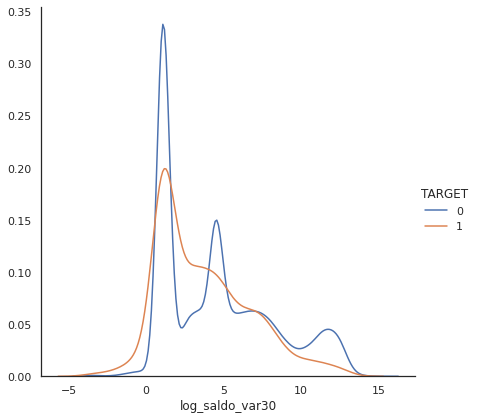

In [ ]:
# Let's look at the density of the age of happy/unhappy customers for saldo_var30
sns.FacetGrid(train7.toPandas(), hue="TARGET", size=6) \
   .map(sns.kdeplot, "log_saldo_var30") \
   .add_legend();

## Explore the interaction between var15 (age) and var38

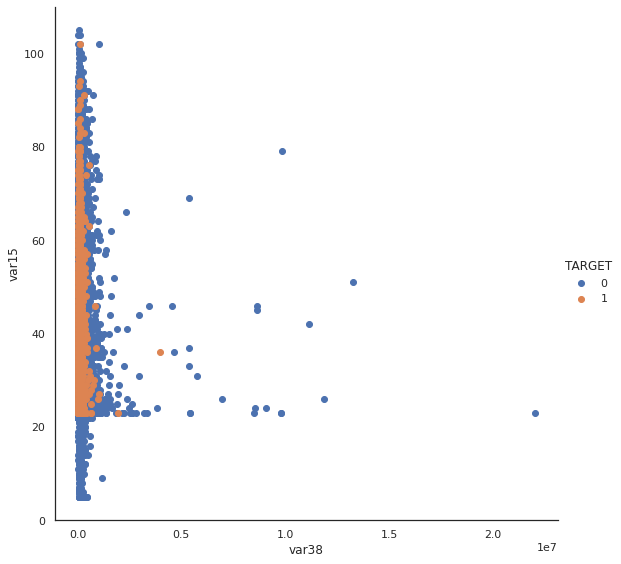

In [ ]:
sns.FacetGrid(train7.toPandas(), hue="TARGET", size=8) \
   .map(plt.scatter, "var38", "var15") \
   .add_legend()

(0.0, 120.0)

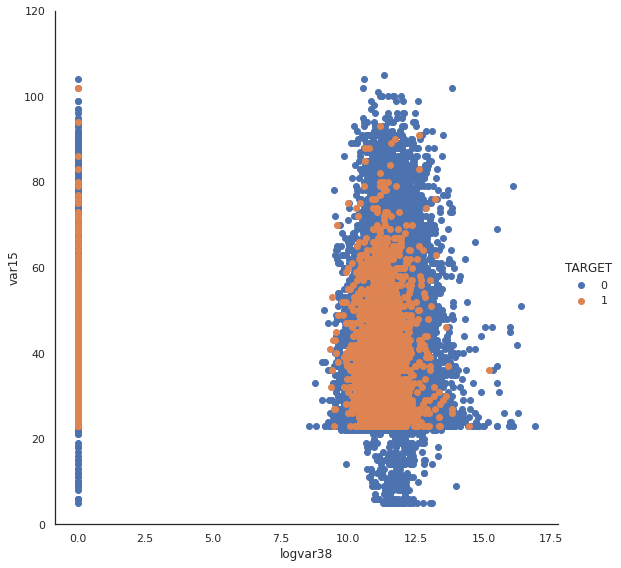

In [ ]:
# Age must be positive
sns.FacetGrid(train7.toPandas(), hue="TARGET", size=8) \
   .map(plt.scatter, "logvar38", "var15") \
   .add_legend()
plt.ylim([0,120])

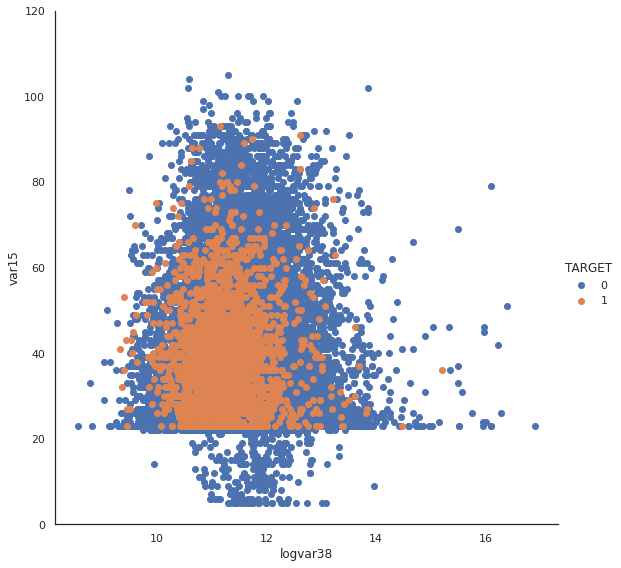

In [ ]:
# Exclude most common value for var38 
sns.FacetGrid(train7.toPandas()[~train7.toPandas().var38mc], hue="TARGET", size=8) \
   .map(plt.scatter, "logvar38", "var15") \
   .add_legend()
plt.ylim([0,120]);

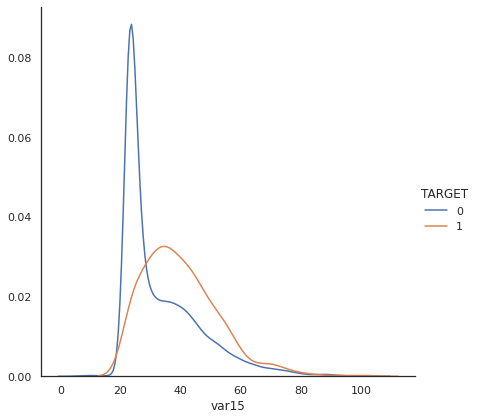

In [ ]:
# What is distribution of the age when var38 has it's most common value ?
sns.FacetGrid(train7.toPandas()[train7.toPandas().var38mc], hue="TARGET", size=6) \
   .map(sns.kdeplot, "var15") \
   .add_legend()

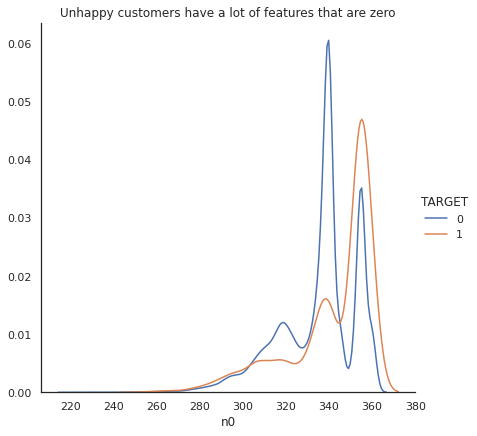

In [ ]:
# What is density of n0?
sns.FacetGrid(train7.toPandas(), hue="TARGET", size=6) \
   .map(sns.kdeplot, "n0") \
   .add_legend()
plt.title('Unhappy customers have a lot of features that are zero');

# Select the most important features
* `X` (uppercase): It's a matrix with the predict variables;
* `y` (lowercase): It's a vector (only one column) is the target variable.

[Cell with X and y](https://colab.research.google.com/drive/1ABlNPBBcTvwzBBvq1Zscx6dXuJpUriRF#scrollTo=qxmIK9RiHONf&line=2&uniqifier=1)

In [12]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, Binarizer, ChiSqSelector

In [13]:
# Get column names removing non-necessary exploratory columns in train7
train_cols = train7.drop('ID','TARGET','n0','var38mc','logvar38','log_saldo_var30').columns

## First select features based on chi2 and f_classif

### Feature Vectorization X
[How to Standardize or Normalize Data with PySpark | Work with Continuous Features | PySpark Tutorial](https://www.youtube.com/watch?v=ucOin2KFt9E)

In [14]:
# Define assembler object
vector_assembler = VectorAssembler(inputCols=train_cols, outputCol='vec_features') 

In [15]:
# Apply vectorization in train7 dataset (without ID column)
temp_train = vector_assembler.transform(train7)

In [ ]:
temp_train.select('vec_features','TARGET').show(3, truncate=False)

### Scale X

In [17]:
standard_scaler = StandardScaler(inputCol='vec_features',outputCol='scaled_features')

In [18]:
train_scaled = standard_scaler.fit(temp_train).transform(temp_train)

In [ ]:
train_scaled.select('scaled_features','vec_features','TARGET').show(3, truncate=False)

### Binarize X

In [71]:
binarizer = Binarizer(threshold=0.5, inputCol='scaled_features',outputCol='bin_feature')

In [73]:
train_bin = binarizer.transform(train_scaled)

In [ ]:
train_bin.show(3, truncate=False)

### ChiSqSelector
[pyspark.ml.feature.ChiSqSelector](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.ChiSqSelector)

In [91]:
selector = ChiSqSelector(featuresCol='bin_feature',
                         outputCol='selected_features',
                         labelCol='TARGET',
                         selectorType='percentile',
                         percentile=0.03)

result = selector.fit(train_bin).transform(train_bin)

print("ChiSqSelector output with %.2f of percentile features selected" % selector.getPercentile())
result.select('selected_features').show(3, truncate=False)

ChiSqSelector output with 0.03 of percentile features selected
+---------------------------------------------------+
|selected_features                                  |
+---------------------------------------------------+
|(11,[3,4,10],[1.0,1.0,1.0])                        |
|(11,[0,1,5,6,7,8,10],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(11,[0,1,10],[1.0,1.0,1.0])                        |
+---------------------------------------------------+
only showing top 3 rows



In [ ]:
chi2_model = selector.fit(train_bin)

# 'selectedFeatures' returns 'Array[Int]' with indexes, not values
# https://stackoverflow.com/questions/39606505/chisqselector-real-features-spark
important_features = chi2_model.selectedFeatures

[train7.columns[i] for i in important_features]

In [88]:
# ['ind_var2',
#  'ind_var5_0',
#  'ind_var6',
#  'ind_var8',
#  'ind_var12_0',
#  'ind_var12',
#  'ind_var13_0',
#  'ind_var13_corto_0',
#  'ind_var13_medio',
#  'ind_var24_0',
#  'ind_var30_0']

In [ ]:
# Chi2 selected 12 features 
#   ['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var5', 'num_var8_0', 'num_var30_0', 'num_var30', 'num_var42', 'saldo_var30', 'var36', 'num_meses_var5_ult3'].
# F_classif selected 12 features 
#   ['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var4', 'num_var5', 'num_var30', 'num_var35', 'num_var42', 'var36', 'num_meses_var5_ult3', 'n0'].
# Chi2 & F_classif selected 9 features
#   ['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var5', 'num_var30', 'num_var42', 'var36', 'num_meses_var5_ult3']

# Save Modified train dataset

In [ ]:
# Save dataset 1
train.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train_output.parquet')

In [ ]:
# Save dataset 2
train2.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train2_output.parquet')

In [ ]:
# Save dataset 3
train3.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train3_output.parquet')

In [ ]:
# Save dataset 4
train4.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train4_output.parquet')

In [ ]:
# Save dataset 5
train5.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train5_output.parquet')

In [ ]:
# Save dataset 6
train6.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train6_output.parquet')

In [ ]:
# Save dataset 7
train7.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/train7_output.parquet')

In [ ]:
# Save X with ID column
X.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/X_output.parquet')

In [ ]:
# Save y
y.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/y_output.parquet')

In [ ]:
result.write.save('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/result.parquet')

# Load saved parquet files

In [ ]:
train = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/08-apache-spark/projects/data/train_output.parquet')
train.cache()

In [ ]:
train2 = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/08-apache-spark/projects/data/train2_output.parquet')
train2.cache()

In [11]:
train7 = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/08-apache-spark/projects/data/train7_output.parquet')
train7.cache()

DataFrame[ID: int, var3: int, var15: int, imp_ent_var16_ult1: double, imp_op_var39_comer_ult1: double, imp_op_var39_comer_ult3: double, imp_op_var40_comer_ult1: double, imp_op_var40_comer_ult3: double, imp_op_var40_efect_ult1: double, imp_op_var40_efect_ult3: double, imp_op_var40_ult1: double, imp_op_var41_comer_ult1: double, imp_op_var41_comer_ult3: double, imp_op_var41_efect_ult1: double, imp_op_var41_efect_ult3: double, imp_op_var41_ult1: double, imp_op_var39_efect_ult1: double, imp_op_var39_efect_ult3: double, imp_op_var39_ult1: double, imp_sal_var16_ult1: double, ind_var1_0: int, ind_var1: int, ind_var2_0: int, ind_var2: int, ind_var5_0: int, ind_var5: int, ind_var6_0: int, ind_var6: int, ind_var8_0: int, ind_var8: int, ind_var12_0: int, ind_var12: int, ind_var13_0: int, ind_var13_corto_0: int, ind_var13_corto: int, ind_var13_largo_0: int, ind_var13_largo: int, ind_var13_medio_0: int, ind_var13_medio: int, ind_var13: int, ind_var14_0: int, ind_var14: int, ind_var17_0: int, ind_var

In [ ]:
# X WITH ID variable
X = spark.read.parquet('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/X_output.parquet')
X.cache()

In [ ]:
# X WITHOUT ID variable
X = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/08-apache-spark/projects/data/X_without_ID_column_output.parquet')
X.cache()

In [ ]:
y = spark.read.parquet('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/y_output.parquet')
y.cache()

In [ ]:
result = spark.read.parquet('/content/drive/My Drive/Colab Notebooks/08-apache-spark/projects/data/result.parquet')
result.cache()

DataFrame[ID: int, var3: int, var15: int, imp_ent_var16_ult1: double, imp_op_var39_comer_ult1: double, imp_op_var39_comer_ult3: double, imp_op_var40_comer_ult1: double, imp_op_var40_comer_ult3: double, imp_op_var40_efect_ult1: double, imp_op_var40_efect_ult3: double, imp_op_var40_ult1: double, imp_op_var41_comer_ult1: double, imp_op_var41_comer_ult3: double, imp_op_var41_efect_ult1: double, imp_op_var41_efect_ult3: double, imp_op_var41_ult1: double, imp_op_var39_efect_ult1: double, imp_op_var39_efect_ult3: double, imp_op_var39_ult1: double, imp_sal_var16_ult1: double, ind_var1_0: int, ind_var1: int, ind_var2_0: int, ind_var2: int, ind_var5_0: int, ind_var5: int, ind_var6_0: int, ind_var6: int, ind_var8_0: int, ind_var8: int, ind_var12_0: int, ind_var12: int, ind_var13_0: int, ind_var13_corto_0: int, ind_var13_corto: int, ind_var13_largo_0: int, ind_var13_largo: int, ind_var13_medio_0: int, ind_var13_medio: int, ind_var13: int, ind_var14_0: int, ind_var14: int, ind_var17_0: int, ind_var